In [29]:
%matplotlib ipympl


In [30]:
%matplotlib ipympl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from ipywidgets import interact, FloatSlider, HBox
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
import mplcursors


In [31]:
df = pd.read_csv("../processed_datasets/merged_aqi_revenue_geocode_dataset.csv")
df["Average_AQI"] = pd.to_numeric(df["Average_AQI"], errors="coerce")
df["Total_Rev_Prog_Desc"] = pd.to_numeric(df["Total_Rev_Prog_Desc"], errors="coerce")

min_aqi, max_aqi = df["Average_AQI"].min(), df["Average_AQI"].max()
df["Normalized_AQI"] = (df["Average_AQI"] - min_aqi) / (max_aqi - min_aqi)

min_rev, max_rev = df["Total_Rev_Prog_Desc"].min(), df["Total_Rev_Prog_Desc"].max()
df["Normalized_Revenue"] = (df["Total_Rev_Prog_Desc"] - min_rev) / (max_rev - min_rev)

def aqi_to_pm25(aqi):
    if   aqi <=  50: return (aqi/50)*12.0
    elif aqi <= 100: return ((aqi-50)/50)*(35.4-12.1)+12.1
    elif aqi <= 150: return ((aqi-100)/50)*(55.4-35.5)+35.5
    elif aqi <= 200: return ((aqi-150)/50)*(150.4-55.5)+55.5
    else:             return 150.4

gdf = (
    gpd.GeoDataFrame(
        df,
        geometry=df.apply(lambda r: Point(r["Longitude"], r["Latitude"]), axis=1),
        crs="EPSG:4326",
    )
    .to_crs(epsg=3857)
)
fixed_bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]


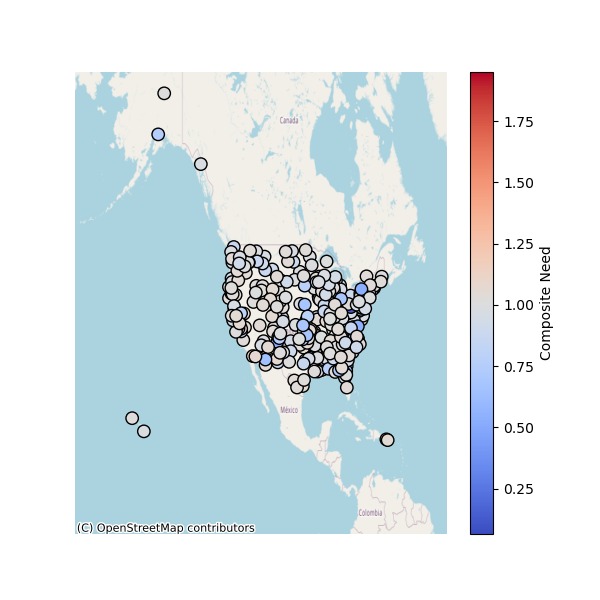

In [32]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(*fixed_bounds[[0,2]])
ax.set_ylim(*fixed_bounds[[1,3]])
ax.set_axis_off()

ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    crs="EPSG:3857",
    reset_extent=False
)

# compute initial composite need at 0% increase
df["New_AQI"] = df["Average_AQI"]
df["New_PM25"] = df["New_AQI"].apply(aqi_to_pm25)
df["Risk_Factor"] = 1 + df["New_PM25"]/10*0.06
df["Composite_Need"] = df["Risk_Factor"] - df["Normalized_Revenue"]
values = df["Composite_Need"].values

# TwoSlopeNorm centered at median, symmetric max deviation
mid = np.median(values)
maxdev = np.max(np.abs(values-mid))
norm = TwoSlopeNorm(vmin=mid-maxdev, vcenter=mid, vmax=mid+maxdev)

scatter = ax.scatter(
    gdf.geometry.x, gdf.geometry.y,
    c=values,
    cmap="coolwarm",
    norm=norm,
    s=80,
    edgecolor="k"
)

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"),
    ax=ax,
    orientation="vertical"
)
cbar.set_label("Composite Need")

cursor = mplcursors.cursor(scatter, hover=True)
@cursor.connect("add")
def _(sel):
    i = sel.index
    sel.annotation.set_text(f"{df.iloc[i]['City']}, {df.iloc[i]['State']}")


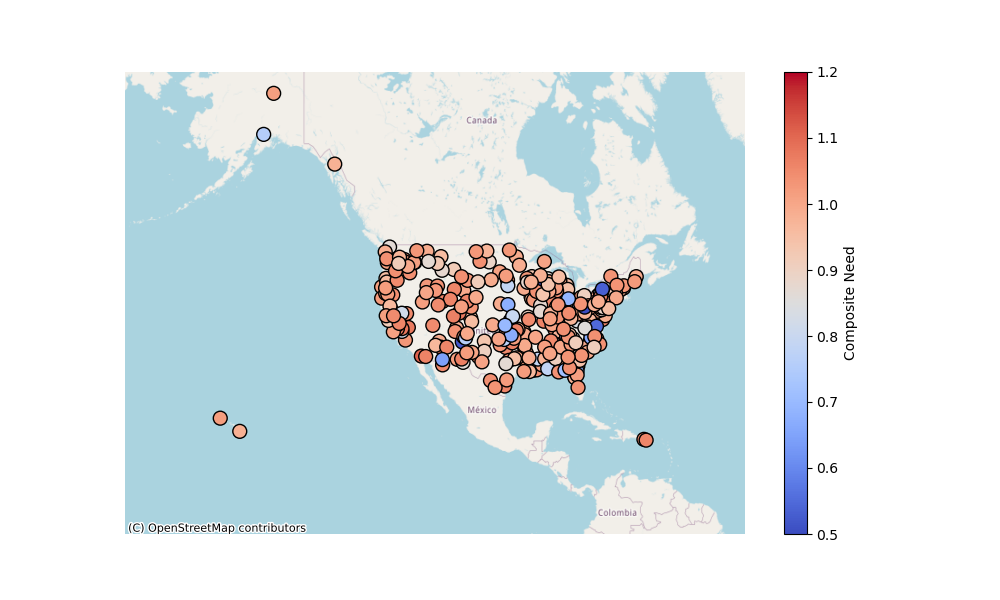

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(fixed_bounds[0], fixed_bounds[2])
ax.set_ylim(fixed_bounds[1], fixed_bounds[3])
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs="EPSG:3857", reset_extent=False)

# initial values at 0% AQI increase
df["New_AQI"] = df["Average_AQI"]
df["New_PM25"] = df["New_AQI"].apply(aqi_to_pm25)
df["Risk_Factor"] = 1 + df["New_PM25"]/10*0.06
df["Composite_Need"] = df["Risk_Factor"] - df["Normalized_Revenue"]
initial = df["Composite_Need"].values

norm = mpl.colors.Normalize(vmin=0.5, vmax=1.2)
scatter = ax.scatter(
    gdf.geometry.x, gdf.geometry.y,
    c=initial, cmap="coolwarm", norm=norm, s=100, edgecolor="k"
)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), ax=ax)
cbar.set_label("Composite Need")

cursor = mplcursors.cursor(scatter, hover=True)
@cursor.connect("add")
def _(sel):
    i = sel.index
    city = df.iloc[i]["City"]
    state = df.iloc[i]["State"]
    sel.annotation.set_text(f"{city}, {state}")


In [34]:
def update(aqi_increase):
    df["New_AQI"] = df["Average_AQI"] * (1 + aqi_increase)
    df["New_PM25"] = df["New_AQI"].apply(aqi_to_pm25)
    df["Risk_Factor"] = 1 + df["New_PM25"]/10*0.06
    df["Composite_Need"] = df["Risk_Factor"] - df["Normalized_Revenue"]
    scatter.set_array(df["Composite_Need"].values)
    ax.set_title(f"Composite Need Heatmap (AQI +{aqi_increase*100:.0f}%)")
    fig.canvas.draw_idle()

slider = FloatSlider(min=0.0, max=0.5, step=0.05, value=0.0, description="AQI +%")
interact(update, aqi_increase=slider)


interactive(children=(FloatSlider(value=0.0, description='AQI +%', max=0.5, step=0.05), Output()), _dom_classe…

<function __main__.update(aqi_increase)>